# CSE 559 Final Project

Author: Yunhe Li, Zeyuan Zong

This project is face detection & blurring, with facial expression estimation

This script is the test for facial expression estimation.

Goal: Given a face image, which type of facial expression will be outputed. facial expression classes: [angry, disgust, fear, happy, neutral, sad, surprise]

Todo: 
1. Design a model to connect input and output
2. Train the CNN model for a few epochs to see the convergence 
3. Test on our implemented CNN model
4. We found built-in facial expression model from face-recognition, we will use it as a comparision. 

In [2]:
import torchvision.models as models
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, SubsetRandomSampler
import torch
from torch import optim
import numpy as np
from tqdm import tqdm
from keras.models import model_from_json
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from torch.utils import tensorboard
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

## Build the model 

For the model selection, we decided to use resnet-50 as the feature extraction. 

After we embedded the features, we map all the features first to high dimensions and then back to 7 different classes with nonlinear ReLu() connected in between.

In [3]:
backbone = models.resnet50(weights='IMAGENET1K_V2')  
num_ftrs = backbone.fc.in_features
# Add two linear layers and relu at the end
backbone.fc = nn.Sequential(
    nn.Linear(num_ftrs, 512),
    nn.ReLU(),
    nn.Linear(512, 7)
)
# for name, param in backbone.named_parameters():
#     param.requires_grad = False           
# for p in backbone.fc.parameters():
#     p.requires_grad = True                 

## Load the data

Load data. 

Need to be attention that the original image is in grayscale, but resnet-50 allows color input. We need to broadcast the grayscale images to the colored channels. 

In [4]:
root = "dataset"          #  ←  the directory that contains /train  and /test

# 48×48 → 224×224, 3-channel copy, normalise to ImageNet stats
common_tfms = [
    transforms.Grayscale(num_output_channels=3),   # 1→3 channels
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),
]

train_tfms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    *common_tfms,
])
val_tfms = transforms.Compose(common_tfms)

train_ds = datasets.ImageFolder(f"{root}/fer2013/train", transform=train_tfms)
test_ds  = datasets.ImageFolder(f"{root}/fer2013/test",  transform=val_tfms)


num_samples    = 15000
all_indices    = np.arange(len(train_ds))
np.random.seed(42)
chosen_indices = np.random.choice(all_indices, size=num_samples, replace=False)


val_frac = 0.1
val_size = int(num_samples * val_frac)
train_size = num_samples - val_size

np.random.shuffle(chosen_indices)
train_idxs = chosen_indices[:train_size]
val_idxs   = chosen_indices[train_size:]

train_sampler = SubsetRandomSampler(train_idxs)
val_sampler   = SubsetRandomSampler(val_idxs)

train_loader = DataLoader(train_ds, batch_size=64, num_workers=4, pin_memory=True,sampler=train_sampler)
val_loader   = DataLoader(train_ds,   batch_size=64, num_workers=4, pin_memory=True,sampler=val_sampler)

In [5]:
model = models.resnet50(weights="IMAGENET1K_V2")
model.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)  # already 3-ch
num_ftrs = model.fc.in_features
model.fc  = nn.Linear(num_ftrs, 7) 

device   = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")
model    = model.to(device)
criterion= nn.CrossEntropyLoss()
optimizer= optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)

writer = tensorboard.SummaryWriter(log_dir="runs/fer_resnet50") 

for epoch in range(15):
    # Training...
    model.train()
    running_loss = 0.0
    train_bar = tqdm(total=len(train_idxs), desc=f"Epoch {epoch:02d} [Train]", unit="img", dynamic_ncols=True)

    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * x.size(0)
        train_bar.update(x.size(0))
        train_bar.set_postfix(loss=loss.item())

    train_bar.close()

    # Validation...
    model.eval()
    correct = total = 0
    val_bar = tqdm(total=len(val_idxs), desc=f"Epoch {epoch:02d} [Valid]", unit="img", dynamic_ncols=True)

    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            pred = model(x).argmax(1)
            correct += (pred == y).sum().item()
            total   += y.size(0)
            val_bar.update(x.size(0))

    val_bar.close()

    train_loss = running_loss / len(train_loader.dataset)
    val_acc    = 100 * correct / total

    # <<<<<<<<<<<< Add TensorBoard logs here
    writer.add_scalar('Loss/train', train_loss, epoch)
    writer.add_scalar('Accuracy/val', val_acc, epoch)

    print(f"Epoch {epoch:02d}: train loss {train_loss:.4f}  val acc {val_acc:.2f}%")

# after all epochs
writer.close()

Using cuda device


Epoch 00 [Valid]: 100%|██████████| 1500/1500 [00:16<00:00, 91.43img/s] 


Epoch 00: train loss 0.6961  val acc 47.07%


Epoch 01 [Valid]: 100%|██████████| 1500/1500 [00:17<00:00, 87.55img/s] 


Epoch 01: train loss 0.5758  val acc 50.67%


Epoch 02 [Valid]: 100%|██████████| 1500/1500 [00:16<00:00, 89.99img/s] 


Epoch 02: train loss 0.5371  val acc 55.07%


Epoch 03 [Valid]: 100%|██████████| 1500/1500 [00:16<00:00, 89.78img/s] 


Epoch 03: train loss 0.5052  val acc 56.20%


Epoch 04 [Valid]: 100%|██████████| 1500/1500 [00:17<00:00, 84.14img/s] 


Epoch 04: train loss 0.4798  val acc 56.80%


Epoch 05 [Valid]: 100%|██████████| 1500/1500 [00:17<00:00, 87.90img/s] 


Epoch 05: train loss 0.4569  val acc 54.93%


Epoch 06 [Valid]: 100%|██████████| 1500/1500 [00:16<00:00, 90.54img/s] 


Epoch 06: train loss 0.4374  val acc 59.07%


Epoch 07 [Valid]: 100%|██████████| 1500/1500 [00:16<00:00, 91.54img/s] 


Epoch 07: train loss 0.4165  val acc 59.60%


Epoch 08 [Valid]: 100%|██████████| 1500/1500 [00:16<00:00, 93.38img/s] 


Epoch 08: train loss 0.4000  val acc 58.47%


Epoch 09 [Valid]: 100%|██████████| 1500/1500 [00:16<00:00, 91.09img/s] 


Epoch 09: train loss 0.3819  val acc 59.27%


Epoch 10 [Valid]: 100%|██████████| 1500/1500 [00:16<00:00, 91.11img/s] 


Epoch 10: train loss 0.3561  val acc 61.00%


Epoch 11 [Valid]: 100%|██████████| 1500/1500 [00:16<00:00, 93.61img/s] 


Epoch 11: train loss 0.3385  val acc 61.27%


Epoch 12 [Valid]: 100%|██████████| 1500/1500 [00:16<00:00, 91.93img/s] 


Epoch 12: train loss 0.3207  val acc 60.27%


Epoch 13 [Valid]: 100%|██████████| 1500/1500 [00:16<00:00, 91.37img/s] 


Epoch 13: train loss 0.2998  val acc 61.20%


Epoch 14 [Valid]: 100%|██████████| 1500/1500 [00:16<00:00, 92.21img/s] 

Epoch 14: train loss 0.2719  val acc 62.53%


In [6]:
test_datagen = ImageDataGenerator(rescale=1.0/255)

test_generator = test_datagen.flow_from_directory(
    directory=os.path.join("dataset", "fer2013", "test"),
    target_size=(48, 48),
    color_mode="grayscale",
    batch_size=64,
    class_mode="categorical",
    shuffle=False
)

Found 7178 images belonging to 7 classes.


In [7]:
model.eval()

correct = total = 0
criterion = nn.CrossEntropyLoss()

test_loader  = DataLoader(test_ds,  batch_size=64, num_workers=4, pin_memory=True)

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total   += labels.size(0)

print(f"[PyTorch] Test accuracy: {correct/total:.4f} ({correct}/{total})")

[PyTorch] Test accuracy: 0.6360 (4565/7178)


In [8]:
# save the model 
model_path = "models/fer_resnet50.pth"
torch.save(model.state_dict(), model_path)

# load the model
# model = models.resnet50(weights="IMAGENET1K_V2")
# model.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)  # already 3-ch
# num_ftrs = model.fc.in_features
# model.fc = nn.Sequential(
#     nn.Linear(num_ftrs, 512),
#     nn.ReLU(),
#     nn.Linear(512, 7)
# )
# model.load_state_dict(torch.load(model_path))
# model.eval()

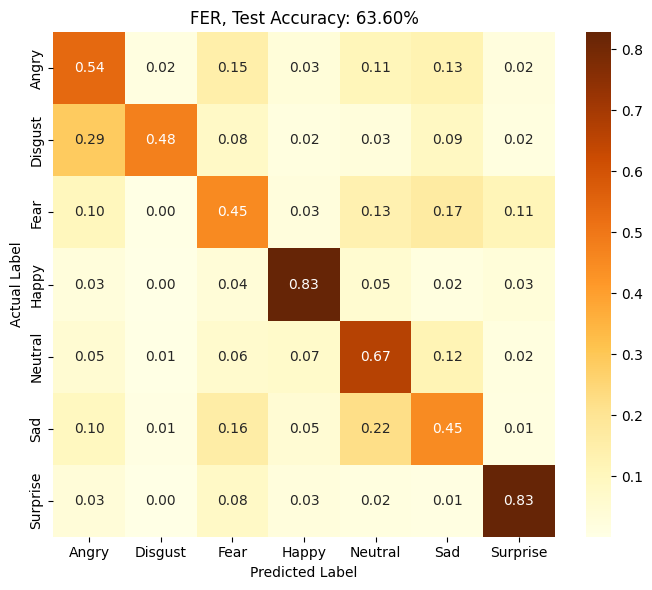

In [9]:
# Assuming you already have a trained model and test_loader
device = "cuda" if torch.cuda.is_available() else "cpu"

# 1. Predict all test images
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        outputs = model(x)
        preds = outputs.argmax(dim=1)

        all_preds.append(preds.cpu().numpy())
        all_labels.append(y.cpu().numpy())

# 2. Flatten lists
all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

# 3. Create confusion matrix
cm = confusion_matrix(all_labels, all_preds)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# 4. Define class names (match the dataset folder order!)
class_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

# 5. Plot the heatmap
plt.figure(figsize=(7,6))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='YlOrBr', 
            xticklabels=class_names, yticklabels=class_names, cbar=True)

plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title(f'FER, Test Accuracy: {100*np.trace(cm)/np.sum(cm):.2f}%')
plt.tight_layout()
plt.show()
